In [141]:
import numpy as np
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
import copy 
import math
from collections import defaultdict
import random

# Config
F_COLOR = (0, 0, 255)
k = 0.04 # For Harris Corner
R_DOWNSAMPLE = 4 # 8
INPUT_DIR = "roof/"
K_RANSAC = 3000 # How many iteration 
N_RANSAC = 8 # How many samples 
RANSAC_THRES = 10
OUTPUT_NAME = "roof_pano"

def gkern(l=5, sig=1.):
    # Reference: https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
    """
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def my_harris_corner(img_gray_f, k=0.04):
    '''
    Input: 
        img - BGR image
        k = 0.04~0.06
    Output: 
        [feature_1, feature_2, feature_3, ...]
    '''
    h ,w = img_gray_f.shape
    x_sobel = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    y_sobel = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]])
    windows_kernal = np.array([[1, 2, 1],
                            [2, 4, 2],
                            [1, 2, 1]])*(1/16)
    # 
    I_x = cv2.filter2D(img_gray_f, -1, x_sobel)
    I_y = cv2.filter2D(img_gray_f, -1, y_sobel)
    # 
    I_x2 = I_x*I_x
    I_y2 = I_y*I_y
    I_xy = I_x*I_y

    # Apply windows function 
    A = cv2.filter2D(I_x2, -1, windows_kernal)# A
    B = cv2.filter2D(I_y2, -1, windows_kernal)# B
    C = cv2.filter2D(I_xy, -1, windows_kernal)# C
    # 
    R = -k*A*A - k*B*B - C*C + (1-2*k)*A*B

    ret, img_R_bin = cv2.threshold(R, R.max()*0.01, 255, cv2.THRESH_BINARY)
    n_region, labels = cv2.connectedComponents(img_R_bin.astype('int8'))

    f_loc = []
    for label in range(1, n_region+1):
        f_loc.append(np.argmax(R*(labels==label)))

    # SIFT feature description
    # Find Major Orientation
    weight_filter = gkern(l = 20, sig = 10)
    M = np.sqrt(I_x2 + I_y2)
    M = np.pad(M, 20, mode='constant', constant_values=0)
    theta = np.arctan2(I_y, I_x)
    theta = np.pad(theta, 20, mode='constant', constant_values=float('nan'))

    maj_ori = [] # majar oridnetation
    for f in f_loc:
        x, y = (f%w, f//w)
        x, y = x+20, y+20 # for padding
        votes = M[y-10:y+10, x-10:x+10] * weight_filter # pad zeros 
        candidates = theta[y-10:y+10, x-10:x+10] # pad nan 
        # 
        votes = votes.ravel() # Reshape to 1D
        candidates = candidates.ravel() # Reshape to 1D
        v_box = defaultdict(int) # voting box
        for i in range(votes.shape[0]):
            if math.isnan(candidates[i]):
                continue
            c = candidates[i]//(math.pi/18)
            v_box[c] += votes[i]
        if len(v_box) == 0:# All candidates are nan
            maj_ori.append((0, 0))
        else:
            winner = max(v_box, key=v_box.get)
            maj_ori.append((winner, v_box[winner]))

    #  Local Orientaion 
    descriptor_s = []
    for f in f_loc:
        x, y = (f%w, f//w)
        x, y = x+20, y+20 # for padding
        
        descriptor = []
        for x_off in [-8, -4, 0, 4]:
            for y_off in [-8, -4, 0, 4]:
                votes = M[y-y_off:y-y_off+8, x-x_off:x-x_off+8]
                candidates = theta[y-y_off:y-y_off+8, x-x_off:x-x_off+8]
                votes = votes.ravel() # Reshape to 1D
                candidates = candidates.ravel() # Reshape to 1D

                v_box = [0, 0, 0, 0, 0, 0, 0, 0]
                for i in range(votes.shape[0]):
                    if math.isnan(candidates[i]):
                        continue
                    c_idx = int((candidates[i]//(math.pi/4)) + 4)
                    if c_idx == 8: c_idx = 7 # Edge case
                    v_box[c_idx] += votes[i]
                descriptor += v_box
        descriptor_s.append(descriptor)

    return list(zip(f_loc, descriptor_s))

def find_boundary(img_pano):
    lb = None # Left bound
    rb = None # Right bound
    for i in range(img_pano.shape[1]):
        if lb == None and np.any(img_pano[:, i]):
            lb = i
        elif lb != None and rb == None and (not np.any(img_pano[:, i])):
            rb = i
            break
    ub = None # Uppder bound
    sb = None # south bound
    for i in range(img_pano.shape[0]):
        if ub == None and np.any(img_pano[i, :]):
            ub = i
        elif ub != None and sb == None and (not np.any(img_pano[i, :])):
            sb = i
            break
    return (lb, rb, ub, sb)

def to_cylinder_cor(ori_p, f_len):
    y, x = h//2 - ori_p[1], -w//2 + ori_p[0]
    xc = f_len*math.atan(x/f_len)
    yc = f_len*y/(math.sqrt(x**2 + f_len**2))
    return (int(xc + w//2), int(-yc + h//2))


## Load Images

Number of image = 20


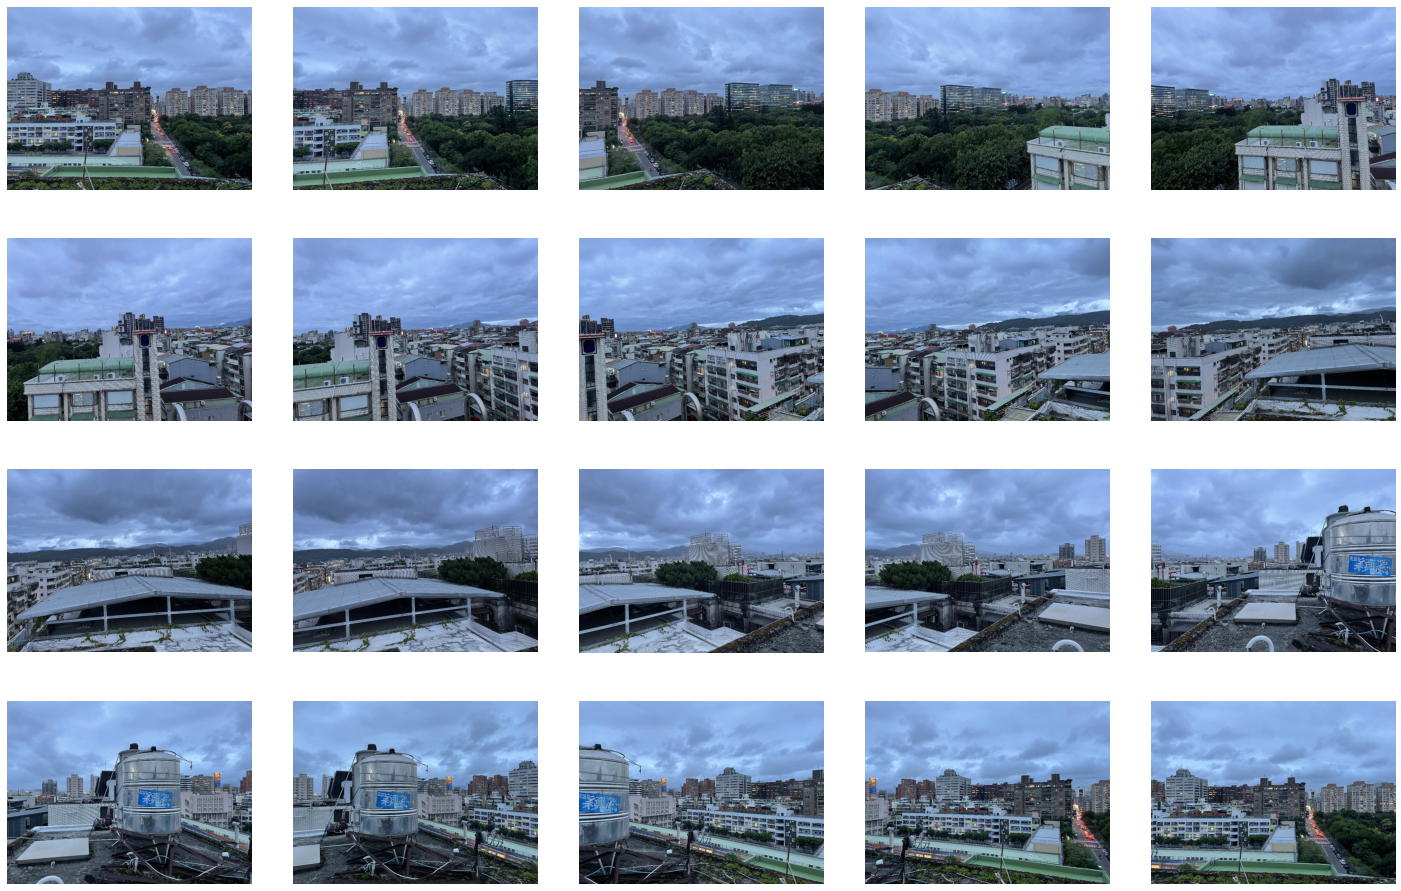

In [145]:
img_list = [cv2.imread(i) for i in sorted(glob.glob(f"{INPUT_DIR}*.jpg"))]
h ,w, c = img_list[0].shape

# Preprocessing Resize
img_list_tmp = [cv2.resize(img, (w//R_DOWNSAMPLE, h//R_DOWNSAMPLE)) for img in img_list]
img_list = img_list_tmp
h ,w, c = img_list[0].shape

# This is for parrington 
f_lens = []
with open(f"{INPUT_DIR}f_len.txt", 'r') as f:
    f_lens = [float(line.split(" ")[1]) for line in f.readlines()]

print(f"Number of image = {len(img_list)}")

fig, ax = plt.subplots(4, 5, figsize=(20, 13))
fig.set_facecolor('white')
fig.tight_layout()
[b.axis('off') for a in ax for b in a ]# Delete all axis
# 
for i in range(len(img_list)):
    ax[i//5, i%5].imshow(img_list[i][...,::-1].copy())

0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20


(-0.5, 1007.5, 755.5, -0.5)

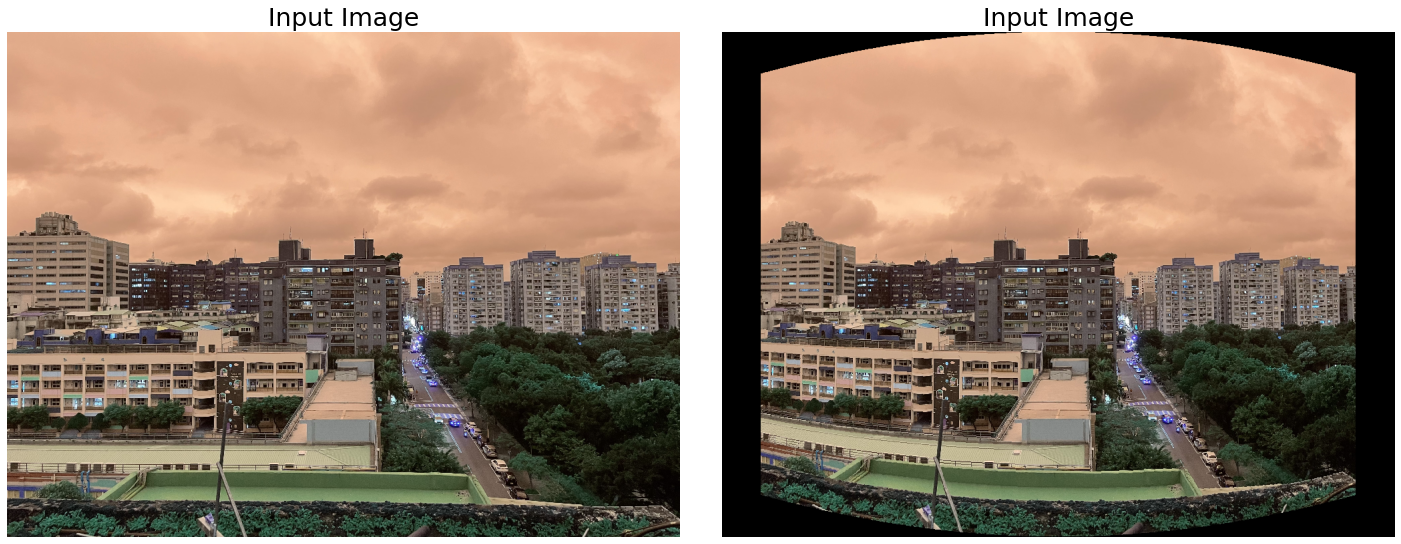

In [121]:
img_cylinders = []

for i in range(len(img_list)):
    img_cylinder = np.zeros(shape=img_list[i].shape, dtype=np.uint8)
    for ori_y in range(h):
        for ori_x in range(w):
            y, x = h//2 - ori_y, -w//2 + ori_x
            xp = f_lens[i]*math.atan(x/f_lens[i])
            yp = f_lens[i]*y/(math.sqrt(x**2 + f_lens[i]**2))
            img_cylinder[int(-yp + h//2), int(xp + w//2)] = img_list[i][ori_y, ori_x]
    img_cylinders.append(img_cylinder)
    print(f"{i}/{len(img_list)}")

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
# 
ax[0].set_title("Input Image", fontsize=25)
ax[0].imshow(img_list[0])
ax[0].axis('off')

ax[1].set_title("Input Image", fontsize=25)
ax[1].imshow(img_cylinders[0])
ax[1].axis('off')

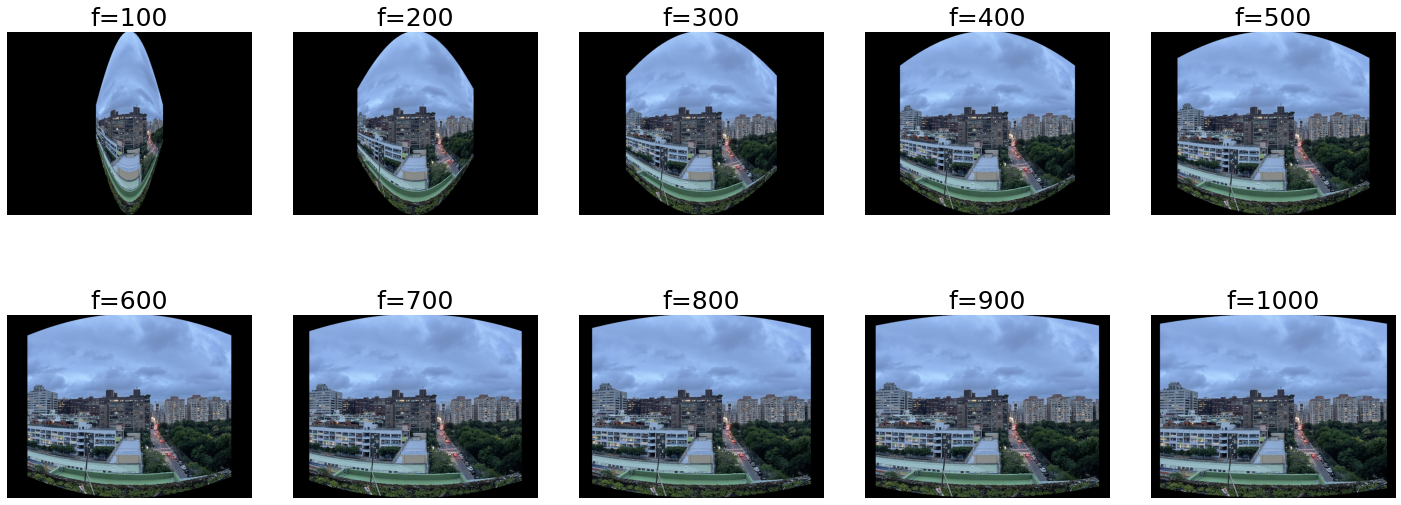

In [149]:

img_list[0] = img_list[0][...,::-1].copy()

results = []
for f_len in [100, 200 ,300 ,400 ,500 ,600, 700 ,800 ,900, 1000]:
    i = 0
    img_cylinder = np.zeros(shape=img_list[i].shape, dtype=np.uint8)
    for ori_y in range(h):
        for ori_x in range(w):
            y, x = h//2 - ori_y, -w//2 + ori_x
            xp = f_len*math.atan(x/f_len)
            yp = f_len*y/(math.sqrt(x**2 + f_len**2))
            img_cylinder[int(-yp + h//2), int(xp + w//2)] = img_list[i][ori_y, ori_x]
    results.append(img_cylinder)

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.set_facecolor('white')
fig.tight_layout()
[b.axis('off') for a in ax for b in a ]# Delete all axis
#
for i in range(10):
    ax[i//5, i%5].set_title(f"f={[100, 200 ,300 ,400 ,500 ,600, 700 ,800 ,900, 1000][i]}", fontsize=25)
    ax[i//5, i%5].imshow(results[i])


## Get all features

In [125]:
my_features_list = []
for i, img in enumerate(img_list):
    # Gray scale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray_f = np.float32(img_gray) # Convert from uint8 to float32
    my_features = my_harris_corner(img_gray_f, k = k)
    my_features_list.append(my_features)
    print(f"Number of harris_corner in img_{i} = {len(my_features)} ")
print(len(my_features_list))

Number of harris_corner in img_0 = 2040 
Number of harris_corner in img_1 = 2198 
Number of harris_corner in img_2 = 1707 
Number of harris_corner in img_3 = 1647 
Number of harris_corner in img_4 = 2054 
Number of harris_corner in img_5 = 1727 
Number of harris_corner in img_6 = 2061 
Number of harris_corner in img_7 = 2086 
Number of harris_corner in img_8 = 2203 
Number of harris_corner in img_9 = 1586 
Number of harris_corner in img_10 = 1390 
Number of harris_corner in img_11 = 1211 
Number of harris_corner in img_12 = 1692 
Number of harris_corner in img_13 = 1859 
Number of harris_corner in img_14 = 1948 
Number of harris_corner in img_15 = 1864 
Number of harris_corner in img_16 = 2356 
Number of harris_corner in img_17 = 2467 
Number of harris_corner in img_18 = 2321 
Number of harris_corner in img_19 = 2189 
20


Number of matched features img_0<->img_1: 613
Reject rate for best match: 23.3% (143/613)
best_dxy = (163, -4)
Number of matched features img_1<->img_2: 440
Reject rate for best match: 23.2% (102/440)
best_dxy = (249, -3)
Number of matched features img_2<->img_3: 266
Reject rate for best match: 42.5% (113/266)
best_dxy = (289, -9)
Number of matched features img_3<->img_4: 236
Reject rate for best match: 40.7% (96/236)
best_dxy = (316, -9)
Number of matched features img_4<->img_5: 405
Reject rate for best match: 42.5% (172/405)
best_dxy = (238, -6)
Number of matched features img_5<->img_6: 542
Reject rate for best match: 34.5% (187/542)
best_dxy = (204, -5)
Number of matched features img_6<->img_7: 541
Reject rate for best match: 42.0% (227/541)
best_dxy = (277, -8)
Number of matched features img_7<->img_8: 747
Reject rate for best match: 24.4% (182/747)
best_dxy = (190, -6)
Number of matched features img_8<->img_9: 538
Reject rate for best match: 36.1% (194/538)
best_dxy = (319, -8)
Nu

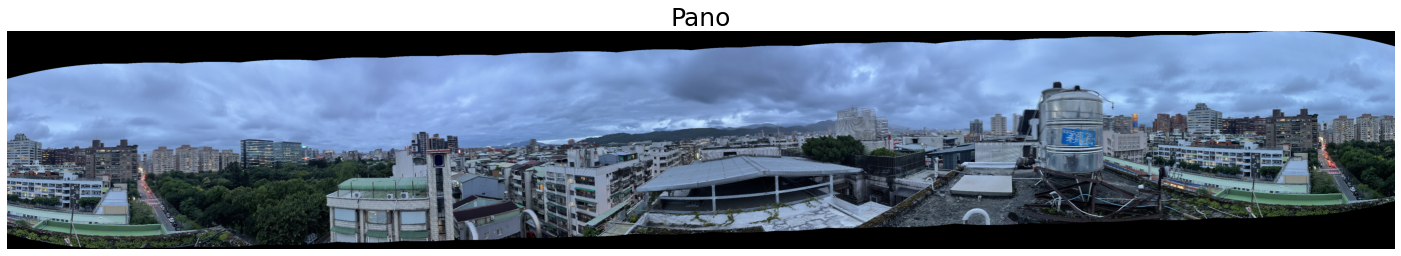

In [128]:
h ,w, c = img_list[0].shape

# Init img_pano with first image
img_pano = np.zeros((2000, 10000, 3), np.uint8)
pano_ori = (0, 1000)
img_pano[pano_ori[1] - h//2:pano_ori[1] + h//2, 
         pano_ori[0]       :pano_ori[0] + w] = img_cylinders[0]

for i_curr in range(1, len(img_list)):
    i_prev = i_curr-1
    
    # Feature Matching
    match = [] # [(f1, f2), (f1, f2)]
    for q, q_des in my_features_list[i_prev]: # Query
        # Find match
        v_idx = None
        d_min_1st = float('inf')
        d_min_2nd = float('inf')
        for v, v_des in my_features_list[i_curr]: # value
            dis = np.linalg.norm(np.array(q_des) - np.array(v_des)) # L2 Distance
            if dis < d_min_1st:
                d_min_2nd = d_min_1st
                d_min_1st = dis
                v_idx = v
        
        # Check if it's a meaningful match
        if d_min_1st/d_min_2nd < 0.8:
            match.append((q, v_idx))
    print(f"Number of matched features img_{i_prev}<->img_{i_curr}: {len(match)}")

    # RANSAC
    min_n_out_dxy = float('inf')
    best_dxy = None # Best translation matrix
    best_match_dxy = None # Best feature set, For debugging 
    for _ in range(K_RANSAC):
        random.shuffle(match)
        dx = 0
        dy = 0
        #
        match_cylider = []
        for f1, f2 in match[:N_RANSAC]:
            x1, y1 = to_cylinder_cor( (f1%w, f1//w) ,f_lens[0])
            x2, y2 = to_cylinder_cor( (f2%w, f2//w) ,f_lens[1])
            # 
            dx += (x1 - x2)/N_RANSAC
            dy += (y1 - y2)/N_RANSAC
            # 
            match_cylider.append((x1 + y1*w, x2 + y2*w))

        # Evluate the number of outliner of this model.
        
        n_outliner_dxy = 0
        for f1, f2 in match:
            x1, y1 = to_cylinder_cor( (f1%w, f1//w) ,f_lens[0]) # TODO transform feature points to cylinder and find dx,dy
            x2, y2 = to_cylinder_cor( (f2%w, f2//w) ,f_lens[1])
            # dxy
            err_squ = ((x2+dx) - x1)**2 + ((y2+dy) - y1)**2
            if err_squ > RANSAC_THRES:
                n_outliner_dxy += 1

        if min_n_out_dxy > n_outliner_dxy:
            min_n_out_dxy = n_outliner_dxy
            best_dxy = (int(dx), int(dy))
            best_match_dxy = match_cylider

    print(f"Reject rate for best match: {round(min_n_out_dxy/len(match)*100, 1)}% ({min_n_out_dxy}/{len(match)})")
    print(f"best_dxy = {best_dxy}")

    pano_ori = (pano_ori[0] + best_dxy[0], pano_ori[1] + best_dxy[1])
    blend_srt = pano_ori[0]
    blend_len = w - best_dxy[0] # blend_end - blend_srt
    blend_end = blend_srt + blend_len # w
    for i in range(blend_srt, blend_end):
        for j in range(h):
            img1_percent = (blend_end - i) / blend_len
            img1_v = img_pano[pano_ori[1] - h//2 + j, i]
            img2_v = img_cylinders[i_curr][j, i-blend_srt]
            
            # Deal with black area
            if not np.any(img1_v): # all zero 
                img1_percent = 0.0
            elif not np.any(img2_v): # all zero 
                img1_percent = 1.0
            #
            img_pano[pano_ori[1] - h//2 + j, i] = img1_v * img1_percent + img2_v * (1-img1_percent)

    # Directly paste non-overlapping part
    img_pano[pano_ori[1] - h//2     :pano_ori[1] + h//2, 
             pano_ori[0] + blend_len:pano_ori[0] + w] = img_cylinders[i_curr][:, blend_len:]

##############################
### Visulize Feature match ###
##############################
# # Draw keypoints
# img_fea_0 = copy.deepcopy(img_list[0])
# for loc, des in my_features_list[0]:
#     cv2.circle(img_fea_0, (loc%w, loc//w), radius = 3, color = F_COLOR, thickness = 1)
# img_fea_1 = copy.deepcopy(img_list[1])
# for loc, des in my_features_list[1]:
#     cv2.circle(img_fea_1, (loc%w, loc//w), radius = 3, color = F_COLOR, thickness = 1)
# img_viz = cv2.hconcat([img_fea_0, img_fea_1])
# # Draw Matched lines
# for f1, f2 in match:
#     img_viz = cv2.line(img_viz, ((f1%w), f1//w), ((f2%w)+w, f2//w), F_COLOR, 1)

###############################
### Visualize RANSAC result ###
###############################
# # Draw keypoints
# img_fea_0 = copy.deepcopy(img_cylinders[0])
# for loc, _ in best_match_dxy:
#     cv2.circle(img_fea_0, (loc%w, loc//w), radius = 3, color = F_COLOR, thickness = 1)
# img_fea_1 = copy.deepcopy(img_cylinders[1])
# for _, loc in best_match_dxy:
#     cv2.circle(img_fea_1, (loc%w, loc//w), radius = 3, color = F_COLOR, thickness = 1)
# img_ransac_viz = cv2.hconcat([img_fea_0, img_fea_1])
# # Draw Matched lines
# for f1, f2 in best_match_dxy:
#     img_ransac_viz = cv2.line(img_ransac_viz, ((f1%w), f1//w), ((f2%w)+w, f2//w), F_COLOR, 1)

lb, rb, ub, sb = find_boundary(img_pano)
img_pano = img_pano[ub:sb, lb:rb]

cv2.imwrite(f"{OUTPUT_NAME}.jpg", img_pano)

# Transform from BGR to RGB
img_pano = img_pano[...,::-1].copy()

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
ax.set_title("Pano", fontsize=25)
ax.imshow(img_pano)
ax.axis('off')
# 

plt.show()

stride_offset = -0.02343199436222692


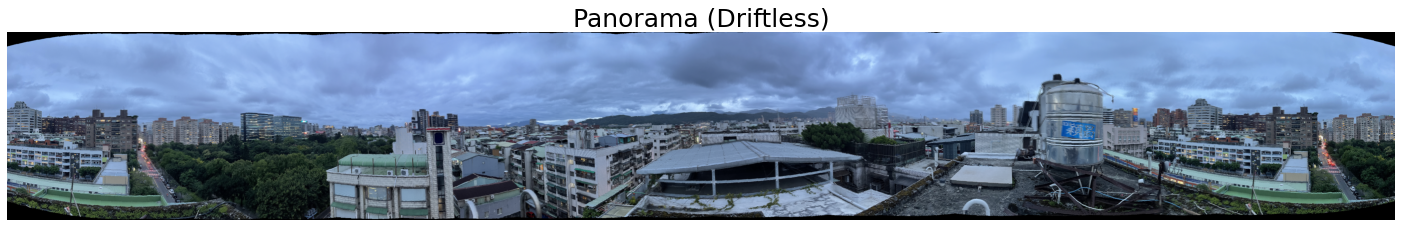

In [142]:
start_black = None
for i in range(img_pano.shape[0]):
    if np.any(img_pano[i, 0]):
        start_black = i
        break
end_black = None
for i in range(img_pano.shape[0]):
    if np.any(img_pano[i, -1]):
        end_black = i
        break

global_offset = end_black - start_black # Assuming drifting down 
stride_offset = global_offset / img_pano.shape[1]
print(f"stride_offset = {stride_offset}")

img_pano_driftless = np.zeros(img_pano.shape, np.uint8)

if stride_offset >= 0:
    for i in range(img_pano.shape[1]):
        img_pano_driftless[:img_pano.shape[0] - int(i*stride_offset), i] = img_pano[int(i*stride_offset):, i]
else:
    stride_offset = abs(stride_offset)
    for i in range(img_pano.shape[1]-1, -1, -1):
        p = int( (img_pano.shape[1]-1-i)*stride_offset )
        img_pano_driftless[:img_pano.shape[0] - p, i] = img_pano[p:, i]

lb, rb, ub, sb = find_boundary(img_pano_driftless)
img_pano_driftless = img_pano_driftless[ub:sb, lb:rb]

img_pano_driftless_tmp = img_pano_driftless[...,::-1].copy()
cv2.imwrite(f"{OUTPUT_NAME}_driftless.jpg", img_pano_driftless_tmp)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
ax.set_title("Panorama (Driftless)", fontsize=25)
ax.imshow(img_pano_driftless)
ax.axis('off')
# 
plt.show()
